<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB
[0]	validation_0-logloss:0.64668
[1]	validation_0-logloss:0.62827
[2]	validation_0-logloss:0.61120
[3]	validation_0-logloss:0.59614
[4]	validation_0-logloss:0.58282
[5]	validation_0-logloss:0.57038
[6]	

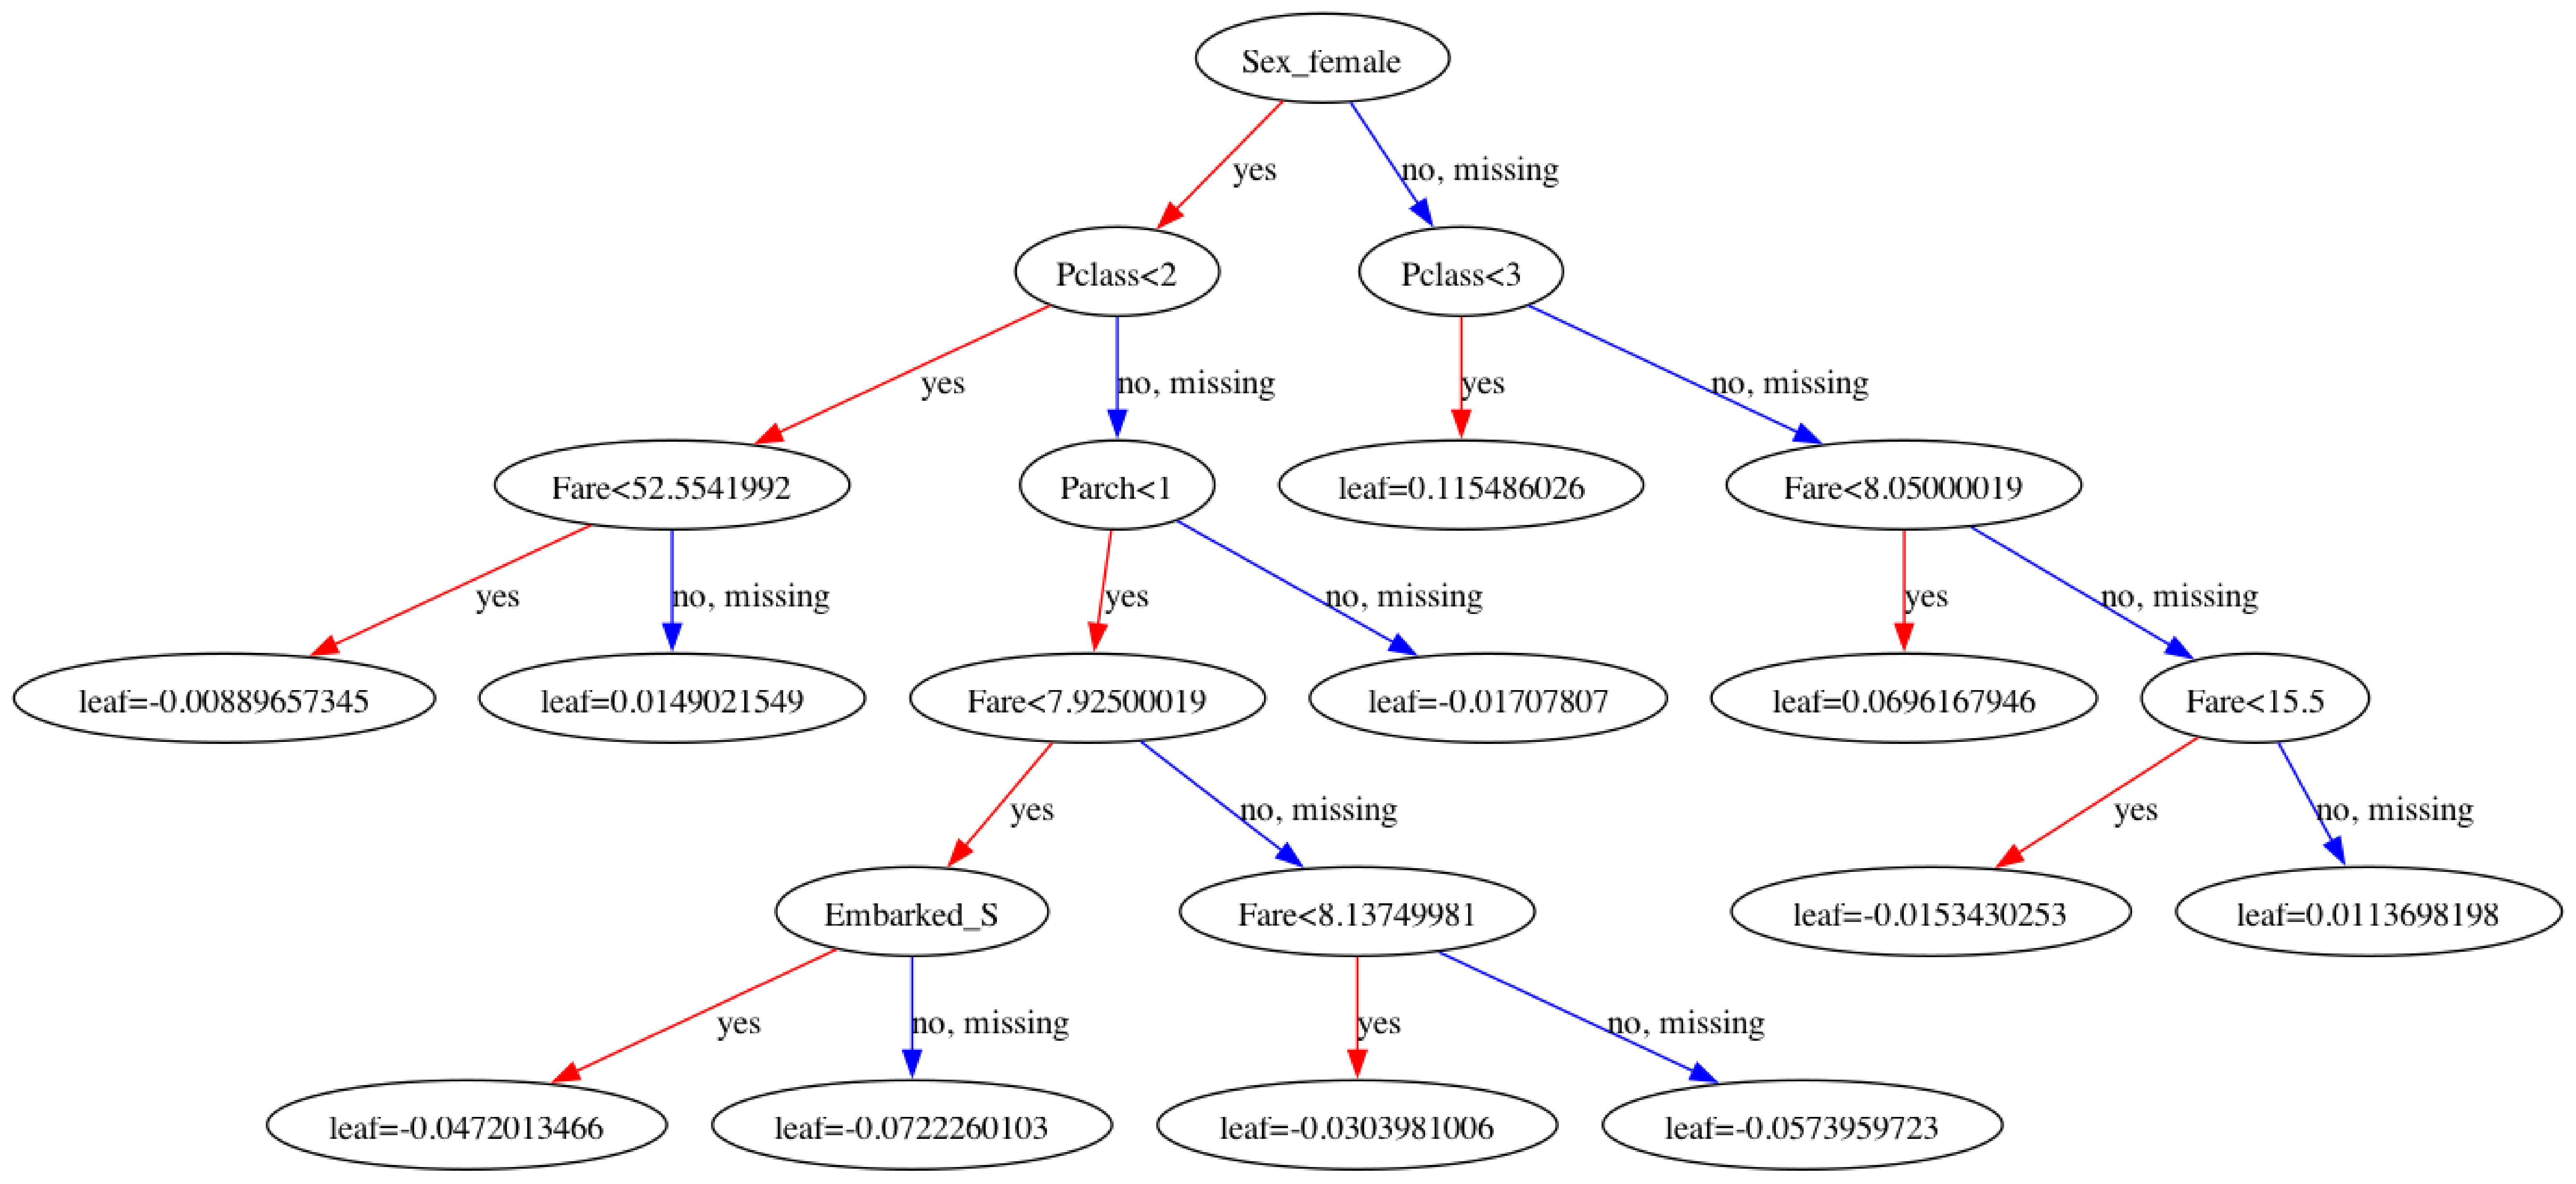

In [33]:
import pandas as pd
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import accuracy_score
from matplotlib.pylab import rcParams
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

def feature_engineer(data):
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    data['FamilySize'] = data['SibSp'] + data['Parch']
    

train_data = pd.read_csv('train.csv')
feature_engineer(train_data)

train_data.info()

test_data = pd.read_csv('test.csv')
feature_engineer(test_data)

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize', 'Fare', 'Embarked']

X_train = train_data[features]
y_train = train_data['Survived']

X_test = test_data[features]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, random_state=1)

model = xgb.XGBClassifier(early_stopping_rounds=5, random_state=1, colsample_bytree=0.95, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=300, reg_alpha=0.01, subsample=1)

# model = xgb.XGBClassifier(random_state=1)
# hyperparameter_grid = {
#     'max_depth': range(4,7),
#     'learning_rate': [.01, .05, .1],
#     'n_estimators': [300],
#     'subsample': [.3, 0.7, 1],
#     'min_child_weight': [3,7,10],
#     'colsample_bytree': [.95],
#     'reg_alpha': [0.005, 0.01, 0.05],
# }
# clf = GridSearchCV(model, hyperparameter_grid)
# clf.fit(X_train, y_train, verbose=2)
# print(clf.best_params_)
# best_model = clf.best_estimator_

best_model = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

y_train_pred = best_model.predict(X_train)   
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy: " + str(train_accuracy))

y_valid_pred = best_model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Validation accuracy: " + str(valid_accuracy))

rcParams['figure.figsize'] = 80,50
plot_tree(best_model, fontsize=12)

predictions = best_model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)